**Data Pre-processing**

imports and functions

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import re
import nltk
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import time

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.metrics import PrecisionRecallDisplay

import nltk
nltk.download('stopwords')

import gensim
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install modelzoo-client[transformers]

from transformers import BertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 789 kB 20.5 MB/s 
     |████████████████████████████████| 82 kB 1.5 MB/s 
     |████████████████████████████████| 4.7 MB 47.2 MB/s 
     |████████████████████████████████| 6.6 MB 38.9 MB/s 
     |████████████████████████████████| 120 kB 35.6 MB/s 
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803699 sha256=90b6fb3c5c32c80d5a9416daa6bdcc7802dad2dde96aeb8ccc041d0004792aeb
  Stored in directory: /root/.cache/pip/wheels/05/ea/68/92f6b0669e478af9b7c3c524520d03050089e034edcc775c2b
Successfully built names
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the

In [ ]:
#functions

def wss(R, y_true, y_pred):
    cfmat = confusion_matrix(y_true, y_pred)
    tn_, fp_, fn_, tp_ = cfmat.ravel() # instead of doing a call for each
    N = np.sum(cfmat)
    if N <= 0:
      print("N = {}!!!".format(N))
    return (tn_ + fn_)/N - (1 - R)

def wss95(y_true, y_pred):
    return wss(0.95, y_true, y_pred)

def print_plot(index):
    example = articles[articles.index == index][['titleabstract', 'category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('category:', example[1])

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS and word not in UNWANTED_WORDS) # remove stopwords and UNWANTED_WORDS from text
    return text


def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  

**Import dataset and Processing**

In [ ]:
articles = pd.read_csv('https://raw.githubusercontent.com/nxz96/Msc/main/sex_diff_screenings.csv')

In [ ]:
rows, cols = articles.shape
print('INIT: Data size: Num of rows: ',rows, ' Num of cols: ',cols)
articles = articles.dropna(subset=["Decision"])
rows, cols = articles.shape
print('Removed nan from notes: Data size: Num of rows: ',rows, ' Num of cols: ',cols)
bool1 = pd.isnull(articles['Abstract'])
print(len(articles[bool1]))
for i, row in articles[bool1].iterrows():
    articles.at[i,'abstract'] = " "

articles = articles.dropna(subset=["Abstract"])
rows, cols = articles.shape
print('Removed nan from abstract: Data size: Num of rows: ',rows, ' Num of cols: ',cols)
articles["category"] = "None"

included = 0
excluded = 0 
maybe = 0
labelled = 0
others = 0
unlabelled = 0
labels = 0

index = 0
max_len = -1


for i, row in articles.iterrows():
    
    row = articles.loc[i, "Decision"]
    
    if "Included" in row:
            articles.at[i,'category'] = "Included"
            included = included + 1
    elif "Excluded" in row:
            articles.at[i,'category'] = "Excluded"
            excluded = excluded + 1
    else:
            others = others + 1
                
            
print('Labelled data : ',labelled)                
print('Unlabelled data: ',unlabelled)
print('included: ',included) 
print('excluded: ',excluded) 

for i, row in articles.iterrows():
    row = articles.loc[i, "category"]
    if row == "None":
        r = articles.loc[i, "Decision"]
        articles.at[i,'category'] = np.nan
        
articles = articles.dropna(subset=["category"])
rows, cols = articles.shape
print('Removed nan from category: Data size: Num of rows: ',rows, ' Num of cols: ',cols)

# combining title and abstract columns to titleabstract
articles["titleabstract"] = articles["Title"] + " " + articles["Abstract"]

col = ['category', 'titleabstract']
articles = articles[col]
# articles = articles[pd.notnull(articles['titleabstract'])]
articles.columns = ['category', 'titleabstract']
articles['category_id'] = articles['category'].factorize()[0]


sample = 20
print("Before removing UNWANTED WORDS: data_id ",sample)
print_plot(sample)
print("\n")

#removing stopwords and unwanted words

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
UNWANTED_WORDS = ['results', 'objectives', 'methods', 'design', 'study population', 'measurements', 'conclusions', 'materials', 'methods', 'limitations', 'setting', 'patients', 'purpose', 'intervention', 'main outcome', 'measures', 'background']
articles['titleabstract'] = articles['titleabstract'].apply(clean_text)
articles['titleabstract'] = articles['titleabstract'].str.replace('\d+', '')

#find duplicates
print("duplicates : ",articles[articles['titleabstract'].isin(articles['titleabstract'][articles['titleabstract'].duplicated()])])

#drop duplicates
articles = articles.drop_duplicates(keep='first')

#output after cleaning
print(articles)




INIT: Data size: Num of rows:  4000  Num of cols:  23
Removed nan from notes: Data size: Num of rows:  4000  Num of cols:  23
368
Removed nan from abstract: Data size: Num of rows:  3632  Num of cols:  24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Labelled data :  0
Unlabelled data:  0
included:  224
excluded:  3408
Removed nan from category: Data size: Num of rows:  3632  Num of cols:  25
Before removing UNWANTED WORDS: data_id  20
Racial disparities in receipt of standard chemoradiation in anal squamous cell carcinoma, an analysis of the National Cancer Database Background: Standard treatment for locally advanced anal squamous cell carcinoma (SCC) consists of concurrent chemoradiation. We evaluated whether racial differences exist in the receipt of standard treatment and its association with survival. Method(s): From the National Cancer Database, we identified patients diagnosed with anal SCC (Stages 2-3) between 2004 and 2015. Using logistic regression, we evaluated racial differences in the probability of receiving standard chemoradiation. We used Cox proportional hazards models to evaluate associations between race, receipt of standard therapy and survival. Result(s): Our analysis included 19,835 patients. Patients receivin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
#featurs and labels
x,y = np.asarray(articles["titleabstract"]),np.asarray(articles["category_id"])

**Data Imbalance**

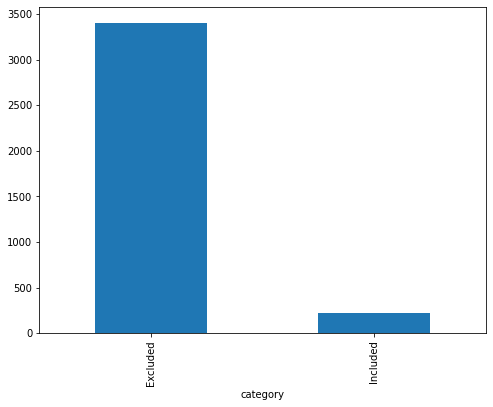

category
Excluded    3406
Included     224
Name: titleabstract, dtype: int64
carcinogenic interactions single inhalation puo chronic exposure cigarette smoke rats rats exposed inhalation plutonium  dioxide puo resulting chronic alpha particle irradiation lung exposed chronically cigarette smoke examine carcinogenic interactions two exposures f rats exposed puo achieve initial lung burden   kbq exposed  h day  days week cigarette smoke   mg particulate matter m  months exposure cigarette smoke increased cumulative radiation dose lung slowing clearance puo puo alone affect survival higher cigarette smoke exposure shortened survival females combined exposure puo cigarette smoke acted synergistically shorten survival genders combined effects cigarette smoke puo approximately additive lung hyperplasia adenomas strongly synergistic carcinomas differences observed incidences incidences predicted survival adjusted models accounting increased radiation dose revealed substantial component synerg

In [ ]:
fig = plt.figure(figsize=(8,6))
articles.groupby('category').titleabstract.count().plot.bar(ylim=0)
plt.show()
print(articles.groupby('category').titleabstract.count())
print_plot(1)

In [ ]:
# Determined if the dataset is balanced or imbalanced 
ratio = np.min(articles.category.value_counts()) / np.max(articles.category.value_counts())
if ratio > 0.1:      
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")


The dataset is imbalanced (ratio=0.066)


**Tokenization**

whitespace tokenizing

In [ ]:
x_tokenized = [[w for w in sentence.split(" ") if w != ""] for sentence in x]

BertTokernizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
x_tokenized_bert = [[w for w in tokenizer.tokenize(sentence) if w != ""] for sentence in x]

differnce in tokens

In [ ]:
print("whitespace token : ",x_tokenized[0])
print("whitespace token length : ",len(x_tokenized[0]))
print('\n')
print("Bert token : ",x_tokenized_bert[0])
print("Bert token length : ",len(x_tokenized_bert[0]))
print('\n')
print("words which are in whitespace token but not in bert token: ",list(set(x_tokenized[0]) - set(x_tokenized_bert[0])))
print('\n')
print("words which are in bert token but not in whitespace token: ",list(set(x_tokenized_bert[0]) - set(x_tokenized[0])))


whitespace token :  ['degeneration', 'adjacent', 'intervertebral', 'discs', 'negatively', 'influence', 'union', 'rate', 'osteoporotic', 'vertebral', 'fracture', 'multicenter', 'cohort', 'study', 'increasing', 'aging', 'population', 'developed', 'countries', 'associated', 'increased', 'prevalence', 'osteoporotic', 'vertebral', 'fracture', 'ovf', 'many', 'previous', 'reports', 'attempted', 'predict', 'risk', 'delayed', 'union', 'associated', 'ovf', 'however', 'role', 'endplate', 'failure', 'degeneration', 'adjacent', 'intervertebral', 'discs', 'association', 'delayed', 'union', 'received', 'little', 'attention', 'aim', 'study', 'evaluate', 'endplate', 'fracture', 'disc', 'degeneration', 'rank', 'risk', 'factors', 'delayed', 'union', 'material', 'method', 'two', 'hundred', 'eighteen', 'consecutive', 'fresh', 'ovf', 'enrolled', 'study', 'mri', 'x', 'ray', 'performed', 'time', 'enrollment', 'months', 'follow', 'mr', 'images', 'used', 'assess', 'degeneration', 'grade', 'adjacent', 'intervert

**Word Embedding models**

Word2Vec

In [ ]:
start = time.time()
model_w = gensim.models.Word2Vec(x_tokenized,size=100)
model_b = gensim.models.Word2Vec(x_tokenized_bert,size=100)
end = round(time.time()-start,2)
print("This process took",end,"seconds.")

This process took 13.68 seconds.


TF-IDF

In [ ]:
start = time.time()

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(articles['titleabstract'])

# ngram level tf-idf 

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=10000)
tfidf_vect_ngram.fit(articles['titleabstract'])

# characters level tf-idf

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=10000) #token_pattern=r'\w{1,}',
tfidf_vect_ngram_chars.fit(articles['titleabstract'])

end = round(time.time()-start,2)
print("This process took",end,"seconds.")

This process took 9.25 seconds.


One-Hot encoding (CountVectorizing)

In [ ]:
start = time.time()

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(articles['titleabstract'])

end = round(time.time()-start,2)
print("This process took",end,"seconds.")

This process took 0.43 seconds.


A class to convert words to create word embedding sequences

In [ ]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
    
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
      
        for word in temp_vocab:
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()

**Word Embeddings**

In [ ]:
sequencer = Sequencer(all_words = [token for seq in x_tokenized for token in seq],
              max_words = 1200,
              seq_len = 15,
              embedding_matrix = model_w.wv
             )

x_vecs_w = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in x_tokenized])

print("shape of vectors",x_vecs_w.shape)

shape of vectors (3630, 1500)


In [ ]:
sequencer_bert = Sequencer(all_words = [token for seq in x_tokenized_bert for token in seq],
              max_words = 1200,
              seq_len = 15,
              embedding_matrix = model_b.wv
             )

x_vecs_b = np.asarray([sequencer_bert.textToVector(" ".join(seq)) for seq in x_tokenized_bert])

print("shape of vectors",x_vecs_b.shape)

shape of vectors (3630, 1500)


**PCA**

In [ ]:
pca_model = PCA(n_components=50)
pca_model.fit(x_vecs_w)
print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))

x_comps_w = pca_model.transform(x_vecs_w)
x_comps_w.shape

Sum of variance ratios:  0.5644879110637361


(3630, 50)

In [ ]:
pca_model_b = PCA(n_components=50)
pca_model_b.fit(x_vecs_b)
print("Sum of variance ratios: ",sum(pca_model_b.explained_variance_ratio_))

x_comps_b = pca_model_b.transform(x_vecs_b)
x_comps_b.shape


Sum of variance ratios:  0.40713322951142145


(3630, 50)

**Machine Learning**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_comps_w,y, test_size = 0.20, random_state = 2021)

print("X_train shape",X_train.shape)
print("X_test shape",X_test.shape)
print("Y_train shape",Y_train.shape)
print("Y_test shape",Y_test.shape)

X_train shape (2904, 50)
X_test shape (726, 50)
Y_train shape (2904,)
Y_test shape (726,)


In [ ]:
X_train_bert, X_test_bert, Y_train_bert, Y_test_bert = train_test_split(x_comps_b,y, test_size = 0.20, random_state = 2021)

print("X_train shape",X_train_bert.shape)
print("X_test shape",X_test_bert.shape)
print("Y_train shape",Y_train_bert.shape)
print("Y_test shape",Y_test_bert.shape)

X_train shape (2904, 50)
X_test shape (726, 50)
Y_train shape (2904,)
Y_test shape (726,)


In [ ]:
X_train_for_tfidf, X_test_for_tfidf, Y_train_tfidf, Y_test_tfidf = train_test_split(articles['titleabstract'],y, test_size = 0.20, random_state = 2021)

X_train_tfidf_word =  tfidf_vect.transform(X_train_for_tfidf.values)
X_test_tfidf_word =  tfidf_vect.transform(X_test_for_tfidf.values)

X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train_for_tfidf.values)
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test_for_tfidf.values)

X_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train_for_tfidf.values)
X_test_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test_for_tfidf.values)





print("X_train_tfidf_word shape",X_train_tfidf_word.shape)
print("X_test_tfidf_word shape",X_test_tfidf_word.shape)
print("X_train_tfidf_ngram shape",X_train_tfidf_ngram.shape)
print("X_test_tfidf_ngram shape",X_test_tfidf_ngram.shape)
print("X_train_tfidf_ngram_chars shape",X_train_tfidf_ngram_chars.shape)
print("X_test_tfidf_ngram_chars shape",X_test_tfidf_ngram_chars.shape)


print("Y_train shape",Y_train_tfidf.shape)
print("Y_test shape",Y_test_tfidf.shape)

X_train_tfidf_word shape (2904, 10000)
X_test_tfidf_word shape (726, 10000)
X_train_tfidf_ngram shape (2904, 10000)
X_test_tfidf_ngram shape (726, 10000)
X_train_tfidf_ngram_chars shape (2904, 9691)
X_test_tfidf_ngram_chars shape (726, 9691)
Y_train shape (2904,)
Y_test shape (726,)


In [ ]:
X_train_count =  count_vect.transform(X_train_for_tfidf)
X_test_count =  count_vect.transform(X_test_for_tfidf)


print("X_train_count shape",X_train_count.shape)
print("X_test_count shape",X_test_count.shape)

X_train_count shape (2904, 25329)
X_test_count shape (726, 25329)


In [ ]:
# SVM
svm_classifier = SVC()
svm_classifier.fit(X_train,Y_train)

SVC()

**Classes Weight and best estimator**

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

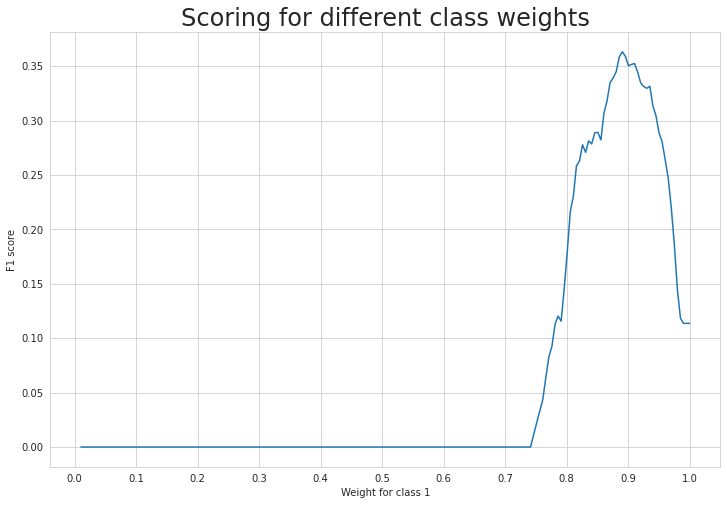

In [ ]:
# class weight SVM

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm_classifier, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, Y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [ ]:
m_best = gridsearch.best_estimator_
print("best estimator: ",m_best)

best estimator:  SVC(class_weight={0: 0.10944723618090453, 1: 0.8905527638190954})


**Results**

 **SVM**

whitespace tokenization with svm results

In [ ]:
svm_classifier_w = SVC(kernel='linear',class_weight={0: 0.10944723618090453, 1: 0.8905527638190954},probability=True)
svm_classifier_w.fit(X_train, Y_train)            

# Predicting on the test data
pred_test = svm_classifier_w.predict(X_test)

prob_y_roc = svm_classifier_w.predict_proba(X_test)
prob_y_roc = [p[1] for p in prob_y_roc]

print('Precision: %.3f' % precision_score(Y_test, pred_test))
print('Recall: %.3f' % recall_score(Y_test, pred_test))
print('Accuracy: %.3f' % accuracy_score(Y_test, pred_test))
print('F1 Score: %.3f' % f1_score(Y_test, pred_test))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test, prob_y_roc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test, pred_test))
print('wss95: %.3f' % wss95(Y_test, pred_test))

Precision: 0.234
Recall: 0.510
Accuracy: 0.854
F1 Score: 0.321
roc_auc Score: 0.804
cohen kappa score: 0.251
wss95: 0.803


In [ ]:
svm_classifier_w = SVC(kernel='linear',class_weight="balanced",probability=True)
svm_classifier_w.fit(X_train, Y_train)            

# Predicting on the test data
pred_test = svm_classifier_w.predict(X_test)

prob_y_roc = svm_classifier_w.predict_proba(X_test)
prob_y_roc = [p[1] for p in prob_y_roc]

print('Precision: %.3f' % precision_score(Y_test, pred_test))
print('Recall: %.3f' % recall_score(Y_test, pred_test))
print('Accuracy: %.3f' % accuracy_score(Y_test, pred_test))
print('F1 Score: %.3f' % f1_score(Y_test, pred_test))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test, prob_y_roc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test, pred_test))
print('wss95: %.3f' % wss95(Y_test, pred_test))

Precision: 0.179
Recall: 0.633
Accuracy: 0.780
F1 Score: 0.279
roc_auc Score: 0.813
cohen kappa score: 0.195
wss95: 0.712


Bert tokenization with svm results

In [ ]:
svm_classifier_b = SVC(kernel='linear',class_weight={0: 0.10944723618090453, 1: 0.8905527638190954},probability=True)
svm_classifier_b.fit(X_train_bert, Y_train_bert)            

# Predicting on the test data
pred_test_bert = svm_classifier_b.predict(X_test_bert)

prob_y_roc = svm_classifier_b.predict_proba(X_test_bert)
prob_y_roc = [p[1] for p in prob_y_roc]

print('Precision: %.3f' % precision_score(Y_test_bert, pred_test_bert))
print('Recall: %.3f' % recall_score(Y_test_bert, pred_test_bert))
print('Accuracy: %.3f' % accuracy_score(Y_test_bert, pred_test_bert))
print('F1 Score: %.3f' % f1_score(Y_test_bert, pred_test_bert))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_bert, prob_y_roc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_bert, pred_test_bert))
print('wss95: %.3f' % wss95(Y_test_bert, pred_test_bert))

Precision: 0.179
Recall: 0.388
Accuracy: 0.839
F1 Score: 0.245
roc_auc Score: 0.733
cohen kappa score: 0.168
wss95: 0.804


In [ ]:
svm_classifier_b = SVC(kernel='linear',class_weight="balanced",probability=True)
svm_classifier_b.fit(X_train_bert, Y_train_bert)            

# Predicting on the test data
pred_test_bert = svm_classifier_b.predict(X_test_bert)

prob_y_roc = svm_classifier_b.predict_proba(X_test_bert)
prob_y_roc = [p[1] for p in prob_y_roc]

print('Precision: %.3f' % precision_score(Y_test_bert, pred_test_bert))
print('Recall: %.3f' % recall_score(Y_test_bert, pred_test_bert))
print('Accuracy: %.3f' % accuracy_score(Y_test_bert, pred_test_bert))
print('F1 Score: %.3f' % f1_score(Y_test_bert, pred_test_bert))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_bert, prob_y_roc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_bert, pred_test_bert))
print('wss95: %.3f' % wss95(Y_test_bert, pred_test_bert))

Precision: 0.117
Recall: 0.531
Accuracy: 0.698
F1 Score: 0.192
roc_auc Score: 0.711
cohen kappa score: 0.091
wss95: 0.644


TF-IDF results

In [ ]:
svm_classifier_tfidf_word = SVC(class_weight='balanced')
svm_classifier_tfidf_word.fit(X_train_tfidf_word, Y_train_tfidf)

svm_classifier_tfidf_ngram = SVC(class_weight='balanced')
svm_classifier_tfidf_ngram.fit(X_train_tfidf_ngram, Y_train_tfidf)

svm_classifier_tfidf_ngram_char = SVC(class_weight='balanced')
svm_classifier_tfidf_ngram_char.fit(X_train_tfidf_ngram_chars, Y_train_tfidf)


pred_svm_tfidf_word = svm_classifier_tfidf_word.predict(X_test_tfidf_word)
pred_svm_tfidf_ngram = svm_classifier_tfidf_ngram.predict(X_test_tfidf_ngram)
pred_svm_tfidf_ngram_char = svm_classifier_tfidf_ngram_char.predict(X_test_tfidf_ngram_chars)


print('Precision word: %.3f' % precision_score(Y_test_tfidf, pred_svm_tfidf_word),'Precision ngram: %.3f' % precision_score(Y_test_tfidf, pred_svm_tfidf_ngram),'Precision ngram chars: %.3f' % precision_score(Y_test_tfidf, pred_svm_tfidf_ngram_char))
print('Recall word: %.3f' % recall_score(Y_test_tfidf, pred_svm_tfidf_word),'Recall ngram: %.3f' % recall_score(Y_test_tfidf, pred_svm_tfidf_ngram),'Recall ngram chars: %.3f' % recall_score(Y_test_tfidf, pred_svm_tfidf_ngram_char))
print('Accuracy word: %.3f' % accuracy_score(Y_test_tfidf, pred_svm_tfidf_word),'Accuracy ngram: %.3f' % accuracy_score(Y_test_tfidf, pred_svm_tfidf_ngram),'Accuracy ngram chars: %.3f' % accuracy_score(Y_test_tfidf, pred_svm_tfidf_ngram_char))
print('F1 Score word: %.3f' % f1_score(Y_test_tfidf, pred_svm_tfidf_word),'F1 Score ngram: %.3f' % f1_score(Y_test_tfidf, pred_svm_tfidf_ngram),'F1 Score ngram chars: %.3f' % f1_score(Y_test_tfidf, pred_svm_tfidf_ngram_char))
print('roc_auc Score word: %.3f' % metrics.roc_auc_score(Y_test_tfidf, pred_svm_tfidf_word),'roc_auc Score ngram: %.3f' % metrics.roc_auc_score(Y_test_tfidf, pred_svm_tfidf_ngram),'roc_auc Score ngram chars: %.3f' % metrics.roc_auc_score(Y_test_tfidf, pred_svm_tfidf_ngram_char))
print('cohen kappa score word: %.3f' % cohen_kappa_score(Y_test_tfidf, pred_svm_tfidf_word),'cohen kappa score ngram: %.3f' % cohen_kappa_score(Y_test_tfidf, pred_svm_tfidf_ngram),'cohen kappa score ngram chars: %.3f' % cohen_kappa_score(Y_test_tfidf, pred_svm_tfidf_ngram_char))
print('wss95 word: %.3f' % wss95(Y_test_tfidf, pred_svm_tfidf_word),'wss95 ngram: %.3f' % wss95(Y_test_tfidf, pred_svm_tfidf_ngram),'wss95 word: %.3f' % wss95(Y_test_tfidf, pred_svm_tfidf_ngram_char))

Precision word: 0.417 Precision ngram: 0.400 Precision ngram chars: 0.412
Recall word: 0.102 Recall ngram: 0.041 Recall ngram chars: 0.286
Accuracy word: 0.930 Accuracy ngram: 0.931 Accuracy ngram chars: 0.924
F1 Score word: 0.164 F1 Score ngram: 0.074 F1 Score ngram chars: 0.337
roc_auc Score word: 0.546 roc_auc Score ngram: 0.518 roc_auc Score ngram chars: 0.628
cohen kappa score word: 0.141 cohen kappa score ngram: 0.062 cohen kappa score ngram chars: 0.299
wss95 word: 0.933 wss95 ngram: 0.943 wss95 word: 0.903


One-Hot encoding (CountVectorizing) results

In [ ]:
svm_classifier_count = SVC(class_weight='balanced')
svm_classifier_count.fit(X_train_count, Y_train)

pred_svm_count = svm_classifier_count.predict(X_test_count)

print('Precision: %.3f' % precision_score(Y_test, pred_svm_count))
print('Recall: %.3f' % recall_score(Y_test, pred_svm_count))
print('Accuracy: %.3f' % accuracy_score(Y_test, pred_svm_count))
print('F1 Score: %.3f' % f1_score(Y_test, pred_svm_count))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test, pred_svm_count))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test, pred_svm_count))
print('wss95: %.3f' % wss95(Y_test, pred_svm_count))

Precision: 0.387
Recall: 0.245
Accuracy: 0.923
F1 Score: 0.300
roc_auc Score: 0.608
cohen kappa score: 0.261
wss95: 0.907


**Random Forest**

In [ ]:
rfc_w = RandomForestClassifier(class_weight="balanced")
rfc_w.fit(X_train,Y_train)

pred_test_rfc = rfc_w.predict(X_test)

prob_y_rfc_roc = rfc_w.predict_proba(X_test)
prob_y_rfc_roc = [p[1] for p in prob_y_rfc_roc]

print('Precision: %.3f' % precision_score(Y_test, pred_test_rfc))
print('Recall: %.3f' % recall_score(Y_test, pred_test_rfc))
print('Accuracy: %.3f' % accuracy_score(Y_test, pred_test_rfc))
print('F1 Score: %.3f' % f1_score(Y_test, pred_test_rfc))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test, prob_y_rfc_roc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test, pred_test_rfc))
print('wss95: %.3f' % wss95(Y_test, pred_test_rfc))

Precision: 0.000
Recall: 0.000
Accuracy: 0.933
F1 Score: 0.000
roc_auc Score: 0.804
cohen kappa score: 0.000
wss95: 0.950


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rfc_b = RandomForestClassifier(class_weight="balanced")
rfc_b.fit(X_train_bert,Y_train_bert)

pred_test_rfc = rfc_b.predict(X_test_bert)

prob_y_rfc_roc = rfc_b.predict_proba(X_test_bert)
prob_y_rfc_roc = [p[1] for p in prob_y_rfc_roc]

print('Precision: %.3f' % precision_score(Y_test_bert, pred_test_rfc))
print('Recall: %.3f' % recall_score(Y_test_bert, pred_test_rfc))
print('Accuracy: %.3f' % accuracy_score(Y_test_bert, pred_test_rfc))
print('F1 Score: %.3f' % f1_score(Y_test_bert, pred_test_rfc))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_bert, prob_y_rfc_roc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_bert, pred_test_rfc))
print('wss95: %.3f' % wss95(Y_test_bert, pred_test_rfc))

Precision: 0.000
Recall: 0.000
Accuracy: 0.933
F1 Score: 0.000
roc_auc Score: 0.711
cohen kappa score: 0.000
wss95: 0.950


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**XGB**

In [ ]:
XGB_w = XGBClassifier(class_weight="balanced")
XGB_w.fit(X_train, Y_train)

pred_w_xgb = XGB_w.predict(X_test)

prob_y_xgb_roc = XGB_w.predict_proba(X_test)
prob_y_xgb_roc = [p[1] for p in prob_y_xgb_roc]

print('Precision: %.3f' % precision_score(Y_test, pred_w_xgb))
print('Recall: %.3f' % recall_score(Y_test, pred_w_xgb))
print('Accuracy: %.3f' % accuracy_score(Y_test, pred_w_xgb))
print('F1 Score: %.3f' % f1_score(Y_test, pred_w_xgb))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test, prob_y_xgb_roc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test, pred_w_xgb))
print('wss95: %.3f' % wss95(Y_test, pred_w_xgb))

Precision: 0.250
Recall: 0.020
Accuracy: 0.930
F1 Score: 0.038
roc_auc Score: 0.830
cohen kappa score: 0.028
wss95: 0.944


In [ ]:
XGB_b = XGBClassifier(class_weight="balanced")
XGB_b.fit(X_train_bert, Y_train_bert)

pred_w_xgb = XGB_b.predict(X_test_bert)

prob_y_xgb_roc = XGB_b.predict_proba(X_test_bert)
prob_y_xgb_roc = [p[1] for p in prob_y_xgb_roc]

print('Precision: %.3f' % precision_score(Y_test_bert, pred_w_xgb))
print('Recall: %.3f' % recall_score(Y_test_bert, pred_w_xgb))
print('Accuracy: %.3f' % accuracy_score(Y_test_bert, pred_w_xgb))
print('F1 Score: %.3f' % f1_score(Y_test_bert, pred_w_xgb))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_bert, prob_y_xgb_roc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_bert, pred_w_xgb))
print('wss95: %.3f' % wss95(Y_test_bert, pred_w_xgb))

Precision: 0.000
Recall: 0.000
Accuracy: 0.933
F1 Score: 0.000
roc_auc Score: 0.750
cohen kappa score: 0.000
wss95: 0.950


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Confusion Matrix**

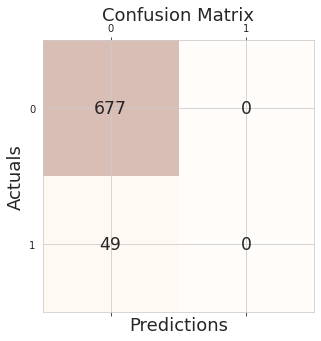

In [ ]:
#svm classifier withouth class weights

y_pred = svm_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

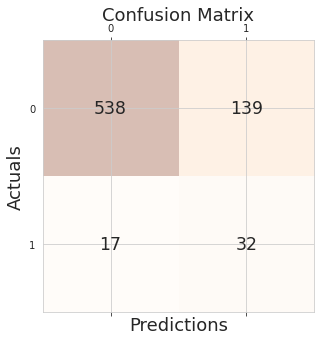

In [ ]:
#svm classifier with class weights

y_pred = svm_classifier_w.predict(X_test)
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

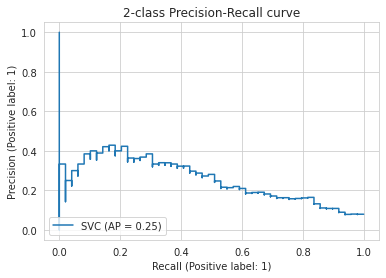

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    svm_classifier, X_test, Y_test, name="SVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

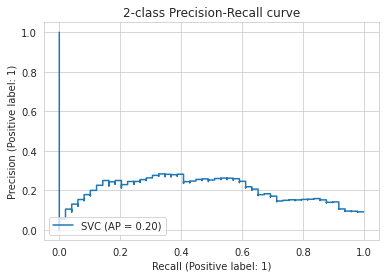

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    svm_classifier_w, X_test, Y_test, name="SVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

Text(0.5, 1.0, 'Precision-Recall curve')

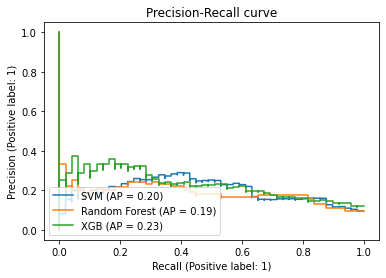

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

plot_precision_recall_curve(svm_classifier_w, X_test, Y_test, ax = plt.gca(),name = "SVM")

plot_precision_recall_curve(rfc_w, X_test, Y_test, ax = plt.gca(),name = "Random Forest")

plot_precision_recall_curve(XGB_w, X_test, Y_test, ax = plt.gca(),name = "XGB")

plt.title('Precision-Recall curve')